## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [80]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext


In [81]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os

path_do_data = "../../datasets/Machine_translation_EN_RU/data.txt"
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = "./data.txt"


Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib

matplotlib.rcParams.update({"figure.figsize": (16, 12), "font.size": 14})
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [83]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())


In [84]:
SRC = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

TRG = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data, format="tsv", fields=[("trg", TRG), ("src", SRC)]
)


In [85]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])


In [86]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")


Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [87]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)


In [88]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")


Unique tokens in source (ru) vocabulary: 9280
Unique tokens in target (en) vocabulary: 6724


Here are tokens from original (RU) corpus:

In [89]:
SRC.vocab.itos[::1000]


['<unk>',
 'sea',
 'tower',
 'каменном',
 'bird',
 'яркие',
 'lan',
 'фруктовые',
 'денпасара',
 'сушки']

And from target (EN) corpus:

In [90]:
TRG.vocab.itos[::1000]


['<unk>', 'tastefully', 'closet', 'douro', 'milas', 'singapore', 'mani']

And here is example from train dataset:

In [91]:
print(vars(train_data.examples[9]))


{'trg': ['guests', 'of', 'pension', 'neumayr', 'can', 'use', 'a', 'sauna', ',', 'infrared', 'cabin', 'and', 'sun', 'terrace', 'with', 'deckchairs', 'free', 'of', 'charge', '.'], 'src': ['в', 'гостевом', 'доме', 'neumayr', 'гости', 'могут', 'бесплатно', 'посещать', 'сауну', 'и', 'пользоваться', 'инфракрасной', 'кабиной', 'и', 'солнечной', 'террасой', 'с', 'шезлонгами', '.']}


Let's check the length distributions:

Length distribution in Train data


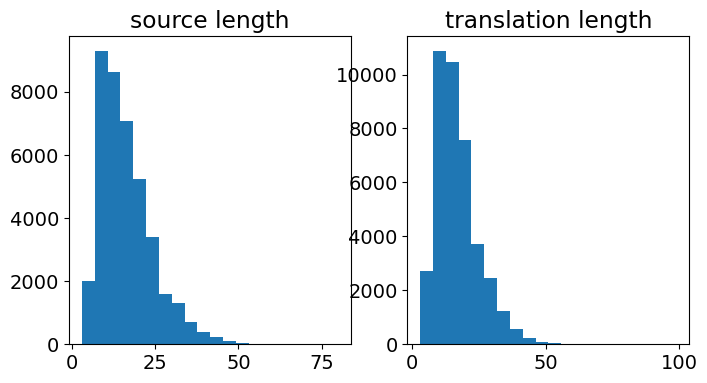

In [92]:
src_length = map(len, [vars(x)["src"] for x in train_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in train_data.examples])

print("Length distribution in Train data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);


### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [93]:
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else 
                      "cpu")


In [94]:
device


device(type='mps')

In [95]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key,
)


In [96]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)



[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.mps.LongTensor of size 46x128]
	[.src]:[torch.mps.LongTensor of size 36x128]
torch.Size([36, 128]) torch.Size([46, 128])


In [97]:
import my_network

Transformer = my_network.Transformer


In [98]:
SRC_VOCAB_SIZE = len(SRC.vocab)
TRG_VOCAB_SIZE = len(TRG.vocab)
D_MODEL = 264
N_HEADS = 4
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DIM_FEEDFORWARD=512
DROPOUT=0.2
MAX_LEN = 1000

SRC_PAD_IDX = SRC.vocab.stoi["<pad>"]

model = Transformer(
    d_model = D_MODEL,
        src_vocab_size = SRC_VOCAB_SIZE,
        trg_vocab_size = TRG_VOCAB_SIZE,
        src_pad_idx = SRC_PAD_IDX,
        n_heads = N_HEADS,
        num_encoder_layers = NUM_ENCODER_LAYERS,
        num_decoder_layers = NUM_DECODER_LAYERS,
        dim_feedforward = DIM_FEEDFORWARD,
        dropout = DROPOUT,
        max_len = MAX_LEN,
        device = device,
).to(device)


RuntimeError: MPS backend out of memory (MPS allocated: 8.98 GB, other allocations: 111.45 MB, max allowed: 9.07 GB). Tried to allocate 6.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
def init_weights(m):
    for layer in m._modules:
        if hasattr(m, "weight"):
            torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)


Transformer(
  (src_word_embedding): Embedding(9280, 512)
  (src_position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (trg_word_embedding): Embedding(6724, 512)
  (trg_position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")


The model has 55,784,004 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = my_network.CosineWarmupScheduler(
    optimizer=optimizer, 
    warmup=(40000 / (BATCH_SIZE * 10)), max_iters=(40000 / BATCH_SIZE)
)
criterion = nn.CrossEntropyLoss(ignore_index=SRC_PAD_IDX)


In [ ]:
def train(
    model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, epoch=1
):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        # trg = [(trg sent len - 1) * batch size]
        # output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        lr_scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)


In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg)  # turn off teacher forcing

            # trg = [trg sent len, batch size]
            # output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            # trg = [(trg sent len - 1) * batch size]
            # output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float("inf")


In [ ]:
for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()

    train_loss = train(
        model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, epoch
    )
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer-model.pt")

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")


RuntimeError: MPS backend out of memory (MPS allocated: 8.93 GB, other allocations: 125.16 MB, max allowed: 9.07 GB). Tried to allocate 26.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten


/var/folders/g9/qd_50t6125vb7v8pbdy0x1rh0000gn/T/ipykernel_80875/2475971412.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [ ]:
batch = next(iter(test_iterator))


In [ ]:
for idx in [1, 2]:
    src = batch.src[:, idx : idx + 1]
    trg = batch.trg[:, idx : idx + 1]
    generate_translation(src, trg, model, TRG.vocab)


Original: the private bathroom comes with a shower .
Generated: end a14 landmark 130 landmark landmark 130 greets greets a14 a14 a14 a14 a14 a14 a14

Original: towels and bed linen are offered .
Generated: pollença pollença città end pollença gregorio gregorio pollença pollença pollença pollença pollença pollença pollença gli gli



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100


In [ ]:
import tqdm


In [ ]:
original_text = []
generated_text = []
#model.load_state_dict(torch.load("transformer-model.pt"))
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg)

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend(
            [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)


0it [00:00, ?it/s]

469it [01:04,  7.22it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100


70.74176357122177

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points